В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [4]:
class NeuralNet:
    
    def __init__(self, layers_sizes, normalize = True, learning_rate = 0.01, num_iter = 15000, costs_iters=300, tol=1e-7, optimization=True):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.layers_sizes = layers_sizes
        self.tol = tol
        self.layers = len(layers_sizes) + 1
        print("Layers: {}".format(self.layers))
        self.costs_iters = costs_iters
        self.optimization = optimization
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / (s+1e-50)         #1e-50 for load_digits dataset
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __sigmoid_derivative(self, A):
        return np.multiply(A, 1 - A)
    
    def __softmax(self, Z):
        e = np.exp(Z)
        return e/np.sum(e, axis=0, keepdims=True)
    
    def __relu(self, Z):
        return np.maximum(0,Z)
    
    def __relu_derivative(self, A):
        return np.greater_equal(A, 0).astype(int)
    
    def __initialize_parameters(self):
        W, b, SdW, Sdb = [], [], [], []
        
        for l in range(1,self.layers+1):
            W_l = np.random.randn(self.layers_sizes[l], self.layers_sizes[l-1]) * 0.01
            b_l = np.zeros((self.layers_sizes[l], 1))
            SdW_l = np.zeros((self.layers_sizes[l], self.layers_sizes[l-1]))
            Sdb_l = np.zeros((self.layers_sizes[l], 1))
            W.append(W_l)
            b.append(b_l)
            SdW.append(SdW_l)
            Sdb.append(Sdb_l)
        
        self.parameters = {"W" : W, "b" : b, "SdW" : SdW, "Sdb" : Sdb}
        
        for key in self.parameters:
            for key_i,i in zip(self.parameters[key],range(len(self.parameters[key]))):
                print("{}{}: {}".format(key,i+1,key_i.shape))
       
    def __forward_propagation(self, X):            
        W = self.parameters["W"]
        b = self.parameters["b"]
        Z, A = [], [] 

        A.append(X)
        for l in range(0,self.layers-1):
            Z_l = np.dot(W[l],A[l]) + b[l]
            A_l = self.__sigmoid(Z_l)
            Z.append(Z_l)
            A.append(A_l)
        
        l = self.layers-1
        Z_l = np.dot(W[l],A[l]) + b[l]
        A_l = self.__softmax(Z_l)
        Z.append(Z_l)
        A.append(A_l)
        
        cache = (Z,A)
        return A[-1], cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
    
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        
        W = self.parameters["W"]
        b = self.parameters["b"]
        (Z,A) = cache
        
        dZ, dW, db = [], [], []
        
        dZ_l = A[-1] - Y
        dW_l = 1. / m * np.dot(dZ_l, A[-2].T)
        db_l = 1. / m * np.sum(dZ_l, axis = 1, keepdims = True)
        
        dZ.insert(0,dZ_l)
        dW.insert(0,dW_l)
        db.insert(0,db_l)
        
        for l in range(self.layers-1,0,-1):
            dA_l = np.dot(W[l].T,dZ_l)
            dZ_l = np.multiply(dA_l, self.__sigmoid_derivative(A[l]))
            dW_l = 1. / m * np.dot(dZ_l, A[l-1].T)
            db_l = 1. / m * np.sum(dZ_l, axis = 1, keepdims = True)
            dZ.insert(0,dZ_l)
            dW.insert(0,dW_l)
            db.insert(0,db_l)
        
        grads = {"dZ":dZ,"dW":dW,"db":db}
        return grads
  
    
    def __update_parameters(self, grads):        
        W = self.parameters["W"]
        b = self.parameters["b"]
        dW = grads["dW"]
        db = grads["db"]
    
        for l in range(0,len(W)):
            W[l] = W[l] - self.learning_rate * dW[l]
            b[l] = b[l] - self.learning_rate * db[l]
            
        self.parameters["W"] = W
        self.parameters["b"] = b

    def __rmsprop(self,grads,beta=0.999):
        W = self.parameters["W"]
        b = self.parameters["b"]
        SdW = self.parameters["SdW"]
        Sdb = self.parameters["Sdb"]
        dW = grads["dW"]
        db = grads["db"]
        
        for l in range(0,len(SdW)):
            SdW[l] = beta * SdW[l] + (1-beta) * np.square(dW[l])
            Sdb[l] = beta * Sdb[l] + (1-beta) * np.square(db[l])
        
        for l in range(0,len(W)):
            W[l] = W[l] - (self.learning_rate * dW[l] / (np.sqrt(SdW[l] + 1e-08)))
            b[l] = b[l] - (self.learning_rate * db[l] / (np.sqrt(Sdb[l] + 1e-08)))
            
        self.parameters["W"] = W
        self.parameters["b"] = b
        self.parameters["SdW"] = SdW
        self.parameters["Sdb"] = Sdb
        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        Y = Y.reshape((Y.shape[0], 1))
        enc = OneHotEncoder(handle_unknown='ignore')
        self.enc = enc
        Y = enc.fit_transform(Y).toarray().astype(int).T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        costs_imp = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        C = Y.shape[0]
        
        self.layers_sizes.insert(0,n_x)
        self.layers_sizes.append(C);
        
        self.__initialize_parameters()

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)
            
            grads = self.__backward_propagation(X, Y, cache)
            
            if self.optimization:
                self.__rmsprop(grads)
            else:
                self.__update_parameters(grads)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)
            
            costs_imp.append(cost)
            if i > self.costs_iters:
                len_imp = len(costs_imp)-1
                if abs(costs_imp[len_imp] - costs_imp[len_imp-self.costs_iters]) < self.tol:
                    print("Stop iteration: {}".format(i))
                    break;

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0].T
        return probs
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        max_cols = positive_probs.max(axis=1).reshape((-1,1))
        pred = (positive_probs == max_cols).astype(int)
        pred = self.enc.inverse_transform(pred)
        pred = pred.reshape((-1,)).T
        return pred

Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

# Dataset

In [5]:
X, Y = load_digits(return_X_y = True)

In [6]:
np.set_printoptions(threshold=np.inf)

In [7]:
#without optimization
cls_noopt = NeuralNet(layers_sizes = [4,6,4], normalize = True, 
                learning_rate = 0.01, num_iter = 10001, tol = 1e-12, costs_iters=1000,optimization=False)

Layers: 4


W1: (4, 64)
W2: (6, 4)
W3: (4, 6)
W4: (10, 4)
b1: (4, 1)
b2: (6, 1)
b3: (4, 1)
b4: (10, 1)
SdW1: (4, 64)
SdW2: (6, 4)
SdW3: (4, 6)
SdW4: (10, 4)
Sdb1: (4, 1)
Sdb2: (6, 1)
Sdb3: (4, 1)
Sdb4: (10, 1)
0-th iteration: 3.2508609986846397
1000-th iteration: 3.2507148967524415
2000-th iteration: 3.2507122028722106
3000-th iteration: 3.2507121527739247
4000-th iteration: 3.2507121518378033
5000-th iteration: 3.2507121518191493
6000-th iteration: 3.2507121518176665
7000-th iteration: 3.2507121518165056
8000-th iteration: 3.2507121518153514
9000-th iteration: 3.250712151814197
10000-th iteration: 3.2507121518130426


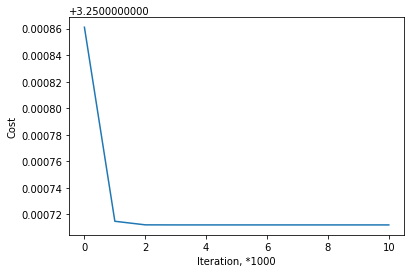

In [8]:
cls_noopt.fit(X, Y)

In [9]:
#with optimization
cls = NeuralNet(layers_sizes = [4,6,4], normalize = True, 
                learning_rate = 0.01, num_iter = 10001, tol = 1e-12, costs_iters=1000,optimization=True)

Layers: 4


W1: (4, 64)
W2: (6, 4)
W3: (4, 6)
W4: (10, 4)
b1: (4, 1)
b2: (6, 1)
b3: (4, 1)
b4: (10, 1)
SdW1: (4, 64)
SdW2: (6, 4)
SdW3: (4, 6)
SdW4: (10, 4)
Sdb1: (4, 1)
Sdb2: (6, 1)
Sdb3: (4, 1)
Sdb4: (10, 1)
0-th iteration: 3.2508802653613897
1000-th iteration: 1.6076170699695673
2000-th iteration: 1.003257290761969
3000-th iteration: 0.8476585097343325
4000-th iteration: 0.6441231406579254
5000-th iteration: 0.43595604421452033
6000-th iteration: 0.4004662997130611
7000-th iteration: 0.37323724296172256
8000-th iteration: 0.36430193994578597
9000-th iteration: 0.37975720096279614
10000-th iteration: 0.3333103971911474


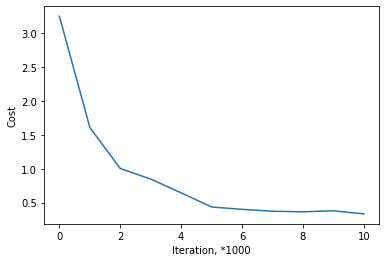

In [10]:
cls.fit(X, Y)

In [11]:
for key in cls.parameters:
    print("{}:\n".format(key))
    for i in cls.parameters[key]:
        print("{}\n".format(i))

W:

[[-1.08279665e-02 -1.93906100e-01 -9.52678975e-02  1.37485535e-01
  -7.71394110e-02  1.12276139e-02 -2.66344807e-01 -4.37132928e+00
  -5.78527423e-02  1.36539836e-01 -6.47171854e-02  7.36830749e-02
   4.37803813e-02  3.37364268e-01  1.24434632e-01  1.65213030e-01
   5.59800130e-02 -6.22474079e-02 -2.99434876e-01 -5.72417530e-01
   2.67350146e-01  1.41676911e-01  4.33893318e-01 -1.87313358e+00
  -1.39764802e+00 -3.37265845e-02 -2.21593554e-01 -2.43122088e-01
  -3.68075141e-01 -3.40465141e-01 -6.17355420e-01 -2.67260525e+00
  -9.40479334e-03 -1.97135260e-01 -1.67068513e-01 -1.07123623e-01
  -3.02443136e-02 -1.66858996e-01 -4.20344899e-01 -1.31712114e-02
  -2.02393062e+00 -8.86139081e-02  2.94644086e-01 -3.25695007e-01
  -6.36417625e-01 -2.98371964e-01 -1.09774940e-01  1.30641483e-01
  -2.41328142e+00 -8.16669286e-02  1.50878794e-01  2.44002241e-01
   5.04788419e-01  6.58542228e-01  2.23336210e-01 -6.66952146e-02
   1.02388248e+00  3.66779255e-01  1.90917415e-01  1.21448730e-01
   4.7

In [12]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[9.88827996e-01, 1.35242300e-03, 2.85600318e-14, 8.89302196e-07,
        3.87376764e-11, 6.32306457e-03, 1.38568213e-03, 5.86327434e-09,
        2.10623551e-03, 3.70335383e-06],
       [7.69766722e-03, 9.66709546e-01, 1.68579674e-24, 3.73041329e-09,
        8.30240677e-12, 1.51581743e-07, 4.36394086e-04, 5.68800334e-08,
        2.50001860e-02, 1.55994894e-04],
       [8.47834843e-17, 7.73476547e-06, 9.44972106e-01, 4.70385570e-02,
        1.45427646e-04, 4.88585703e-06, 3.50808430e-05, 1.86730693e-05,
        7.76764735e-03, 9.88793613e-06],
       [1.07737285e-15, 7.52655955e-07, 1.89917943e-03, 9.89068530e-01,
        4.52094968e-08, 9.88115948e-05, 2.09472891e-09, 6.04185670e-10,
        2.85152085e-03, 6.08115726e-03],
       [1.58936577e-03, 2.36275491e-13, 3.80539427e-32, 3.19662723e-18,
        9.89677476e-01, 3.06326848e-22, 1.95603942e-03, 6.77634262e-03,
        7.75900694e-07, 1.45500969e-13],
       [7.56054754e-07, 4.77563120e-07, 7.85760820e-02, 3.40547719e-02,
   

In [13]:
Y_hat = cls.predict(X)
Y_hat

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 3, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 6,
       7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6,
       6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 1, 1, 4,
       6, 3, 1, 3, 3, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5,
       4, 4, 7, 2, 8, 2, 2, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, 8, 9, 8, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 8, 2, 3,
       4, 5, 6, 7, 1, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 3,
       5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 4, 3, 3, 4, 6, 6, 6,
       4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 8, 7, 3, 7, 3,
       9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5, 4, 4, 7, 2,
       8, 5, 2, 5, 5, 4, 8, 8, 4, 9, 0, 8, 9, 8, 0, 8, 2, 3, 4, 5, 6, 7,
       8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
       0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7,

In [14]:
#1 - not equal y & y_pred
#output number of incorrectly predicted values
np.bincount((Y != Y_hat).astype(int))[1]

81

In [15]:
accuracy_score(Y, Y_hat)

0.9549248747913188